In [65]:
import gooseberry as gs

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import numpy as np

import jax
import jax.numpy as jnp
from functools import partial

from dynamics import QQT
from tools import BlindColours, zero_balanced_weights
import pandas as pd

In [66]:
bc = BlindColours(False)
blind_colours = bc.get_colours()
div_cmap = bc.get_div_cmap()
colour_steps = bc.get_colour_steps()

In [67]:
def logger(params, X, Y, f):
    w2w1 = params["network"]["layer-1"]["w"][0] @ params["network"]["layer-0"]["w"][0]
    Y_hat = params["network"]["layer-1"]["w"][0] @ f(params["network"]["layer-0"]["w"][0] @ X.T)
    loss = 0.5 * np.mean(np.sum((Y_hat.T - Y)**2, axis=1))
    return w2w1, loss

In [4]:
#TODO:

#Defining the forgetting Formula


#Forgetting F on task T_i when training on task T_k after having trained the network on task T_j
#F_i(T_j, T_k) = L_i(T_k) - L_i(T_j)

#1. Define Forgetting Formula.

#2. Do Gradient Descent and Plot Forgetting

#3. Plot Forgetting using QQt

#4. Plot rate of forgetting using Gradient Descent

#5. Plot rate of forgetting using QQt

In [83]:
def get_loss(ws, task):
    data, lables = task(None)
    return 0.5 * np.mean(np.sum((ws @ data.T - labels.T)**2, axis=1))



In [115]:
def balanced_weights(in_dim, hidden_dim, out_dim, c):

    #random number bigger than c:
    a = np.random.exponential(scale = 5) + c 
    b = np.sqrt(a*a - c)

    #TODO: not sure which dimension, doesnt work for hidden_dim > min(out_dim, in_dim)
    S_1 = a * np.eye(max(hidden_dim, in_dim))[:hidden_dim, :in_dim]
    S_2 = b * np.eye(max(out_dim, hidden_dim))[:out_dim, :hidden_dim] 

    random_matrix_one = np.random.rand(hidden_dim, hidden_dim)
    random_matrix_two = np.random.rand(in_dim, in_dim)
    random_matrix_three = np.random.rand(out_dim, out_dim)

    q_one, _ = np.linalg.qr(random_matrix_one)
    q_two, _ = np.linalg.qr(random_matrix_two)
    q_three, _ = np.linalg.qr(random_matrix_three)

    U_1 = q_one 
    V_2 = q_one 
    V_1 = q_two
    U_2 = q_three

    W1 = U_1 @ S_1 @ (V_1.T)
    W2 = U_2 @ S_2 @ (V_2.T)

    return W1, W2 

In [64]:
task_i

NameError: name 'task_i' is not defined

In [ ]:
def training_data(data_x, data_y):
    return data_x, data_y

In [118]:

in_dim = 5
hidden_dim = 10
out_dim = 6

batch_size = 25
learning_rate = 0.05
training_steps = 6000

initial_weight_scale = 0.0001

training_datas = []

datas = []
labels = []
whitened_datas = []

for i in range(3):
    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, 0.3)
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)

# for td in training_datas:
#     data, label = td(None)
#     datas.append(data)
#     labels.append(label)

# for X in datas:
#     scaler = StandardScaler()
#     X_standardized = scaler.fit_transform(X)

#     pca = PCA(whiten=True)
#     X_whitened = pca.fit_transform(X_standardized)
#     whitened_datas.append(X_whitened)


# for i in range(3):
#     training_datas[i] = lambda _: (whitened_datas[i], labels[i])

losses = [[] for _ in range(3)]
analytical_losses = [[] for _ in range(3)]

logs = jax.jit(partial(logger, f=gs.nonlinearities.Identity()))

ws = []
analyticals = []
for i, training_data in enumerate(training_datas):
    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if i == 0:
        init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_weight_scale)
    else:
        init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])
    
    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    
    for training_step in range(training_steps):
        for j, data in enumerate(training_datas):
            X, Y = data(None)
            w2w1, loss = logs(params, X, Y)
            losses[j].append(loss)
        ws.append(w2w1)
        
        state, params, loss = trainer(state, params)
    
    X, Y = training_datas[i](None)
    analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    next = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    analyticals.extend(np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)]))
    



    w2w1s = np.asarray(next)

    for cur, data in enumerate(training_datas):
        curr_X, curr_Y = data(None)
        anal_loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((next @ curr_X.T - curr_Y.T)**2, axis=2), axis=1)
        analytical_losses[cur].extend(anal_loss)


ws = np.asarray(ws)
losses = np.asarray(losses)
analytical_losses = np.asarray(analytical_losses)
analyticals = np.asarray(analyticals)

In [142]:

in_dim = 3
hidden_dim = 3
out_dim = 3

batch_size = 25
learning_rate = 0.05
training_steps = 6000

initial_weight_scale = 0.0001

training_datas = []

datas = []
labels = []
whitened_datas = []

for i in range(3):
    init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, 0.3)
    training_data, _, _ = gs.datasets.RandomRegression(batch_size, in_dim, out_dim, [gs.datasets.Whiten()])
    training_datas.append(training_data)



losses = [[] for _ in range(3)]
analytical_losses = [[] for _ in range(3)]

logs = jax.jit(partial(logger, f=gs.nonlinearities.Identity()))

ws = []
analyticals = []
for i, training_data in enumerate(training_datas):
    task = gs.tasks.FullBatchLearning(training_data)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    if i == 0:
        init_w1, init_w2 = balanced_weights(in_dim, hidden_dim, out_dim, 0.1)
    else:
        init_w1, init_w2 = params["network"]["layer-0"]["w"][0], params["network"]["layer-1"]["w"][0]
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])
    
    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)
    
    for training_step in range(training_steps):
        for j, data in enumerate(training_datas):
            X, Y = data(None)
            w2w1, loss = logs(params, X, Y)
            losses[j].append(loss)
        ws.append(w2w1)
        
        state, params, loss = trainer(state, params)
    
    # X, Y = training_datas[i](None)
    # analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    # next = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    # analyticals.extend(np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)]))
    



    # w2w1s = np.asarray(next)

    # for cur, data in enumerate(training_datas):
    #     curr_X, curr_Y = data(None)
    #     anal_loss = 0.5 * (out_dim / batch_size) * np.mean(np.sum((next @ curr_X.T - curr_Y.T)**2, axis=2), axis=1)
    #     analytical_losses[cur].extend(anal_loss)


ws = np.asarray(ws)
losses = np.asarray(losses)
# analytical_losses = np.asarray(analytical_losses)
# analyticals = np.asarray(analyticals)

/var/folders/x9/316v313n6_g8y8_p7fz_v6cw0000gn/T/ipykernel_71966/2296114909.py:5: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(a*a - c)


In [143]:
ws

array([[[-9.0416414e-01,  5.8589592e+00, -1.0383445e+00],
        [-5.7470226e+00, -5.8773553e-01,  1.6880080e+00],
        [ 1.5418462e+00,  1.2450861e+00,  5.6829166e+00]],

       [[-4.1008979e-01,  2.7850444e+00, -5.3459197e-01],
        [-2.8053007e+00, -2.4814712e-01,  8.2804000e-01],
        [ 7.5365973e-01,  5.5936891e-01,  2.8512444e+00]],

       [[-2.7850434e-01,  2.0011861e+00, -3.9752889e-01],
        [-2.0413601e+00, -1.5931928e-01,  6.0045069e-01],
        [ 5.4719138e-01,  3.8670418e-01,  2.1013541e+00]],

       ...,

       [[ 2.9189742e-01,  3.3581093e-02, -2.9587274e-02],
        [ 6.4112410e-02, -3.1081725e-02, -1.1110856e-01],
        [ 3.6425309e-03, -5.7375219e-02,  6.3789889e-02]],

       [[ 2.9189742e-01,  3.3581093e-02, -2.9587274e-02],
        [ 6.4112410e-02, -3.1081725e-02, -1.1110856e-01],
        [ 3.6425309e-03, -5.7375219e-02,  6.3789889e-02]],

       [[ 2.9189742e-01,  3.3581093e-02, -2.9587274e-02],
        [ 6.4112410e-02, -3.1081725e-02, -1.11108

In [136]:
losses[0]

array([182.74954   ,   7.624837  ,   4.89051   , ...,   0.42138284,
         0.42138284,   0.42138284], dtype=float32)

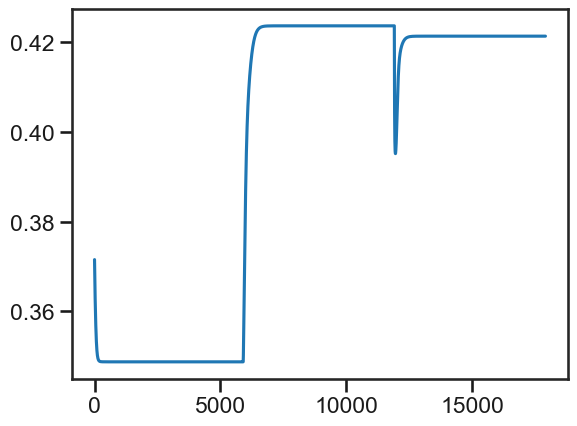

In [148]:
plt.plot(losses[0][100:])

In [121]:
training_datas[0]

functools.partial(<function Dataset.advance_training at 0x128ae0280>, data=Array([[-1.1517748 , -0.3630578 ,  0.847397  ],
       [-0.19304758, -1.3331962 ,  0.29811844],
       [ 0.5947804 , -1.5596713 ,  1.3693893 ],
       [-1.3751919 ,  0.6551207 , -0.10998675],
       [-1.589754  ,  0.14664225, -0.10568949],
       [-0.4773584 ,  0.9893314 ,  0.3877209 ],
       [ 0.5381044 , -1.9525863 ,  0.7762718 ],
       [ 0.37446308,  0.7323192 ,  0.42024282],
       [ 1.1437304 ,  0.8193268 ,  1.5085938 ],
       [-0.10559113,  0.2420952 ,  1.6902859 ],
       [-0.35698432,  0.44349203, -2.1818123 ],
       [-0.38453028,  0.5446709 , -1.4567338 ],
       [ 1.4304616 , -1.5013474 , -0.29276332],
       [-1.9688734 ,  0.74714404,  0.44038364],
       [ 1.7833034 ,  1.9159615 , -0.15162127],
       [ 1.0157919 ,  0.09611668, -0.11694127],
       [-0.49150518, -0.25625548, -0.8131301 ],
       [ 0.82469   , -0.9678156 , -1.2620262 ],
       [-0.32648414,  1.2715926 ,  0.43188187],
       [ 1.53

In [13]:
#Measuring forgetting

#loss on task I from fully training on task J
loss_j = losses[0][6000*2]
analytical_loss_j = analytical_losses[0][6000*2]


fs = []
analytical_fs = []

for i in range(12000, 18000):
    fs.append(losses[0][i] - loss_j)
    analytical_fs.append(analytical_losses[0][i] - analytical_loss_j)



In [27]:
analyticals.shape

analyticals[0]



array([[[-0.19603603, -0.03914941, -0.07588377,  0.05904441,
          0.07125405],
        [-0.05119512,  0.05206004, -0.08410457, -0.06720028,
         -0.10409784],
        [ 0.06105289, -0.09272416,  0.01729216,  0.10035748,
         -0.05579706],
        [-0.10505076, -0.05774979, -0.0315867 ,  0.02145229,
         -0.01049306],
        [ 0.05061349, -0.16620443,  0.05031791,  0.1006982 ,
         -0.01152866],
        [ 0.0984809 ,  0.01027249,  0.11584615,  0.07835467,
         -0.02680113]],

       [[-0.19603553, -0.03914912, -0.07588467,  0.05904499,
          0.07125433],
        [-0.05119525,  0.05205996, -0.08410434, -0.06720043,
         -0.10409791],
        [ 0.06105406, -0.09272347,  0.01729008,  0.10035883,
         -0.0557964 ],
        [-0.10505199, -0.05775051, -0.0315845 ,  0.02145086,
         -0.01049375],
        [ 0.05061297, -0.16620474,  0.05031885,  0.10069759,
         -0.01152895],
        [ 0.09848038,  0.01027218,  0.11584708,  0.07835406,
         -0.0

In [28]:
analyticals[0].shape

(6000, 6, 5)

In [ ]:
ls = []
for i in range(18000):
    ls.append()

In [61]:
#Calculate forgetting a different way (as in the supplementary material)


sigma_yx_i = analyticals[6000]
sigma_yx_j = analyticals[12000]


forgetting_representations = []

for i in range(12000, 18000):
    curr = np.linalg.norm(ws[i] - sigma_yx_i, 'fro')**2 - np.linalg.norm(sigma_yx_j - sigma_yx_i, 'fro')**2
    forgetting_representations.append(curr * 0.5 * (out_dim / batch_size))




In [63]:
task_i

NameError: name 'task_i' is not defined

In [75]:
task_i = training_datas[0]
task_j = training_datas[1]
task_k = training_datas[2]

data_i, label_i = task_i(None)

test_losses = []

for weights in ws: 
    test_losses.append(0.5 * (out_dim / batch_size) * np.linalg.norm(weights @ data_i.T - label_i.T))



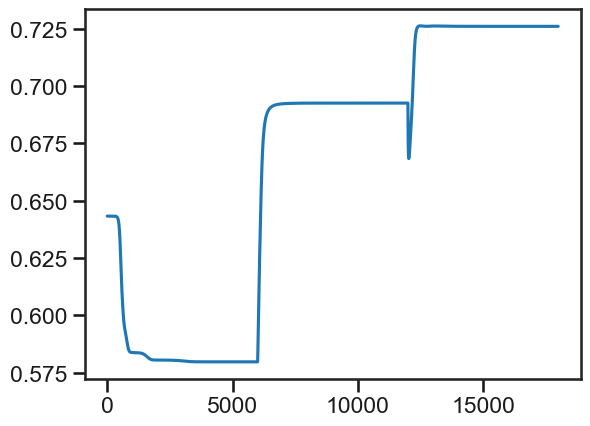

In [76]:
plt.plot(test_losses)

In [80]:
import seaborn as sns

<AxesSubplot: >

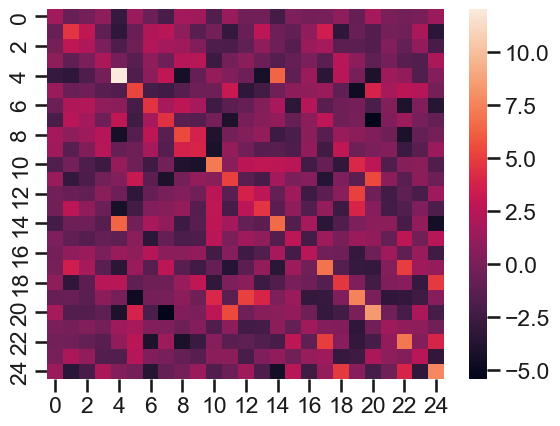

In [81]:
sns.heatmap(data_i @ data_i.T)

In [73]:
ws[0].shape

(6, 5)

In [74]:
data_i.shape



(25, 5)

In [71]:
data_i, label_i = task_i(None)

functools.partial(<function Dataset.advance_training at 0x128ae0280>, data=Array([[-0.0529983 ,  0.64639175,  0.7463098 ,  0.44093022,  0.643022  ],
       [ 1.1417167 ,  0.9438895 , -1.4578416 , -0.56424093,  0.12449063],
       [ 0.60503894,  0.6241629 , -0.7254051 , -0.7760621 ,  0.560258  ],
       [-0.20140058,  0.2817104 ,  1.0893216 , -0.7744287 ,  0.26746258],
       [-1.670098  , -2.7028468 , -0.41984853, -1.1651106 , -0.6414284 ],
       [-0.7123282 ,  0.15073724, -0.548768  ,  1.6529007 ,  1.3020163 ],
       [ 1.026436  , -0.3838975 , -0.23740014, -1.6011696 ,  0.87979287],
       [-0.21279885,  0.10081055, -1.3538324 , -1.4661961 , -0.7049546 ],
       [ 1.0297912 ,  0.9084044 ,  1.273965  , -0.9044206 ,  1.021069  ],
       [-0.06037112,  0.18233548,  1.3959895 , -0.78819996,  1.1381044 ],
       [ 0.8053745 , -0.98129565, -0.5397905 ,  1.380811  , -1.8418235 ],
       [-0.08032776, -1.0875777 ,  0.8257851 ,  1.4375441 ,  1.0495017 ],
       [ 0.59111243,  0.09392908,  0.

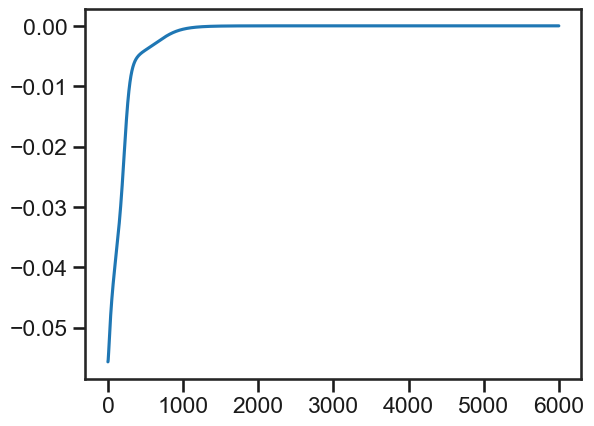

In [62]:
plt.plot(forgetting_representations)



In [57]:
x = [np.linalg.norm(a - sigma_yx_i, 'fro')**2 for a in ws]

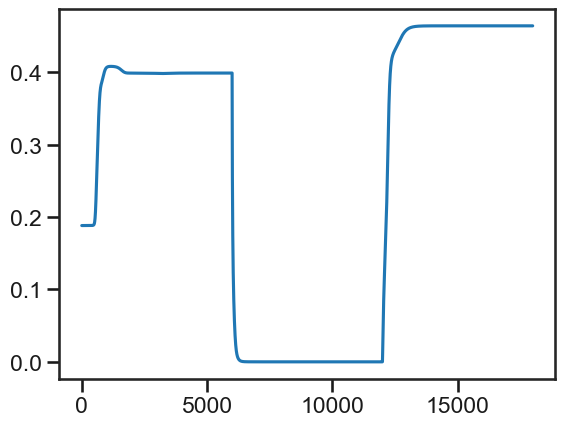

In [58]:
plt.plot(x)

In [42]:
print(sigma_yx_i)

[[-0.1580084  -0.12104903 -0.04338131  0.01355744  0.07321224]
 [ 0.08847406 -0.0042044  -0.01686117  0.03227193 -0.1568738 ]
 [-0.07736541  0.00512509  0.0549708   0.0583288   0.00095762]
 [ 0.12061158  0.15989671  0.01560677  0.07444736  0.11807184]
 [-0.11876494 -0.00714725  0.05172287 -0.00112767  0.03019831]
 [-0.06802505 -0.07714735  0.04716764 -0.06437629 -0.02108761]]


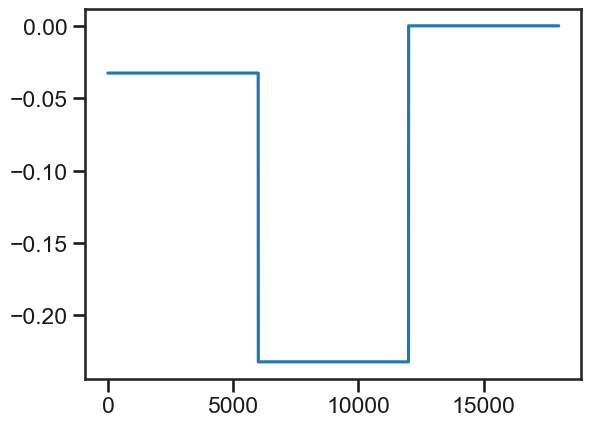

In [39]:
plt.plot(forgetting_representations)



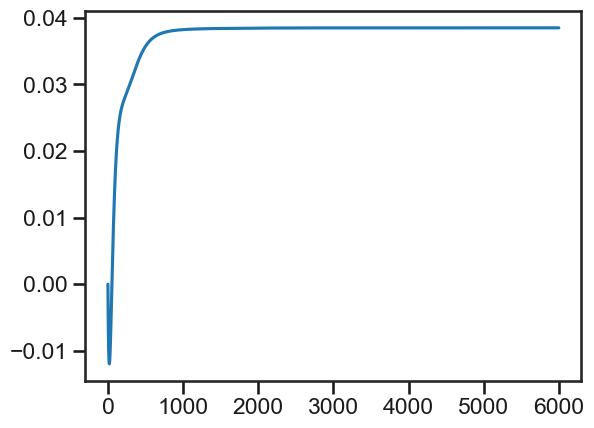

In [14]:
plt.plot(analytical_fs)

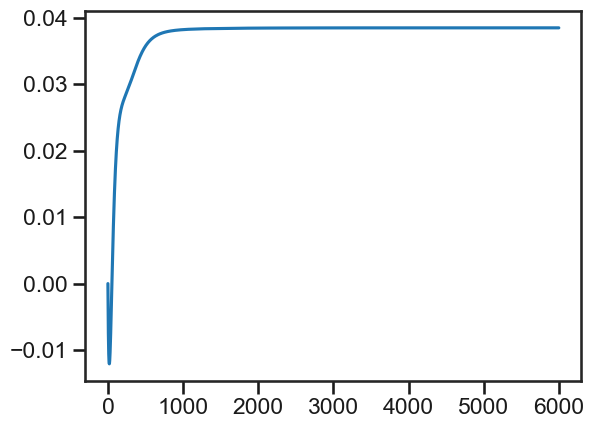

In [10]:
plt.plot(fs)

In [18]:
slope = pd.Series(np.gradient(fs), name='slope')
slope_analytical = pd.Series(np.gradient(analytical_fs), name='slope_analytical')

<AxesSubplot: >

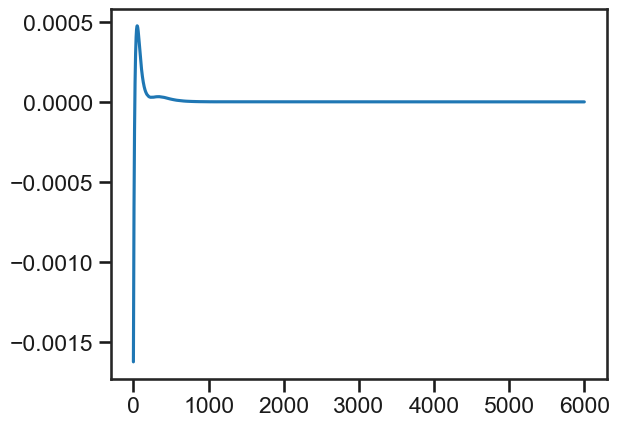

In [19]:
slope.plot()

<AxesSubplot: >

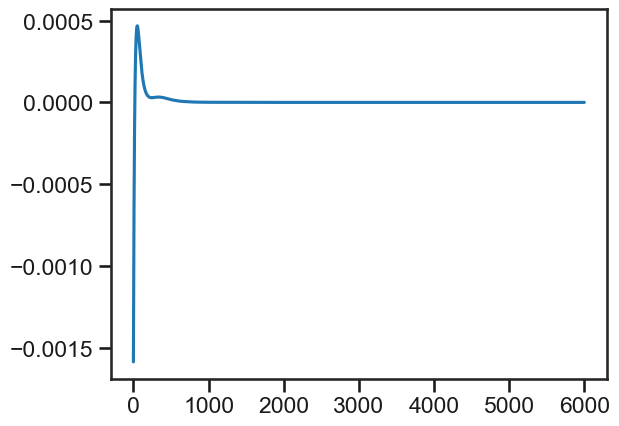

In [20]:
slope_analytical.plot()

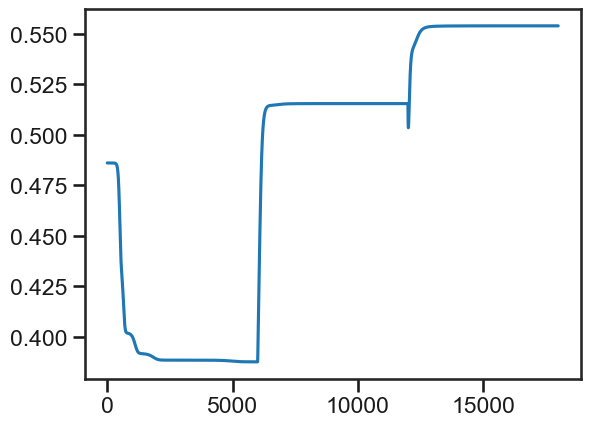

In [7]:
plt.plot(analytical_losses[0], label ='analytical')

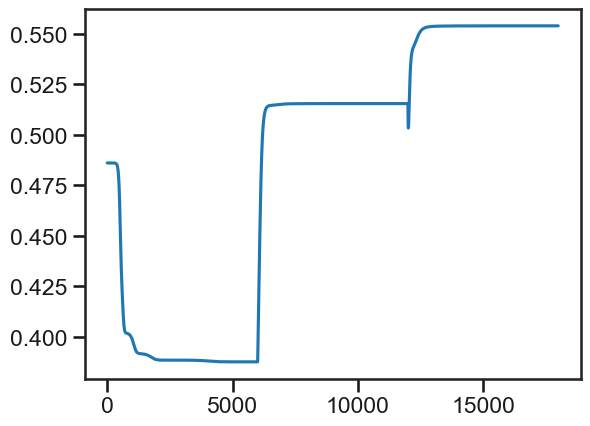

In [6]:
plt.plot(losses[0], label='empirical')

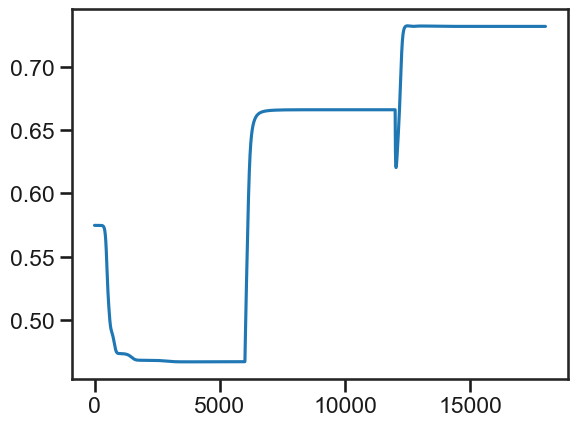

In [138]:
plt.plot(losses[0])

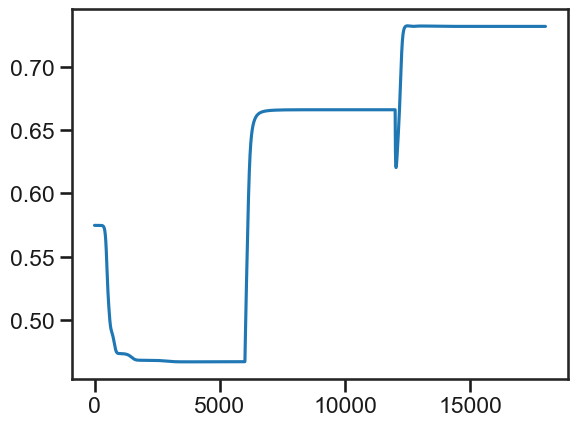

In [109]:
plt.plot(losses[0])

In [95]:
losses

array([[0.57474875, 0.57474875, 0.57474875, ..., 0.73216397, 0.73216397,
        0.73216397],
       [0.47460482, 0.47460482, 0.47460482, ..., 0.6125292 , 0.6125292 ,
        0.6125292 ],
       [0.45646608, 0.45646608, 0.45646608, ..., 0.35982874, 0.35982874,
        0.35982874]], dtype=float32)

In [ ]:
#once you have all analyticals, calculate the losses

In [ ]:
#once you have all losses calculate forgetting in simple way for both analytical and empirical

In [ ]:
#calcualte rate of forgetting

In [ ]:
#calculate forgetting in complex way

In [ ]:
#do everything again for balanced weights

In [68]:
task_i = training_datas[0]
task_j = training_datas[1]
task_k = training_datas[2]

In [23]:
data, labels = task_i(None)

In [24]:
data

Array([[-0.0529983 ,  0.64639175,  0.7463098 ,  0.44093022,  0.643022  ],
       [ 1.1417167 ,  0.9438895 , -1.4578416 , -0.56424093,  0.12449063],
       [ 0.60503894,  0.6241629 , -0.7254051 , -0.7760621 ,  0.560258  ],
       [-0.20140058,  0.2817104 ,  1.0893216 , -0.7744287 ,  0.26746258],
       [-1.670098  , -2.7028468 , -0.41984853, -1.1651106 , -0.6414284 ],
       [-0.7123282 ,  0.15073724, -0.548768  ,  1.6529007 ,  1.3020163 ],
       [ 1.026436  , -0.3838975 , -0.23740014, -1.6011696 ,  0.87979287],
       [-0.21279885,  0.10081055, -1.3538324 , -1.4661961 , -0.7049546 ],
       [ 1.0297912 ,  0.9084044 ,  1.273965  , -0.9044206 ,  1.021069  ],
       [-0.06037112,  0.18233548,  1.3959895 , -0.78819996,  1.1381044 ],
       [ 0.8053745 , -0.98129565, -0.5397905 ,  1.380811  , -1.8418235 ],
       [-0.08032776, -1.0875777 ,  0.8257851 ,  1.4375441 ,  1.0495017 ],
       [ 0.59111243,  0.09392908,  0.9238556 , -0.15497912, -1.5870957 ],
       [ 1.6783363 ,  0.7822451 , -0.1

In [48]:
#I have the data, just have to calculate the loss

def loss(ws, task):
    data, labels = task(None)
    return 0.5 * np.mean(np.sum((ws @ data.T - labels.T)**2, axis=1))

def task_loss(taskj, taski):
    data_j, labels_j = task_j(None)
    data_i, labels_i = task_i(None)

    sigma_yx_j = labels_j.T @ data_j 
    print(labels_j)
    print(data_j)

    return 0.5 * np.mean(np.sum((sigma_yx_j @ data_i - labels_i)**2, axis=1))

    
    

def forgetting(ws, task_i, task_j):
    data_i, labels_i = task_i(None)
    data_j, labels_j = task_j(None)

    # sigma_yx_k = ws
    # sigma_yx_i = labels_i @ data_i
    # sigma_yx_j = labels_j @ data_j
    return 0.5 * loss(ws, task_i)

    #return 1/2 * (loss(ws, task_i) - task_loss(task_j, task_i))
    



In [36]:
data_j, labels_j = task_j(None)

In [45]:
labels_j.T @ data_j

Array([[-3.9502096 , -3.0262258 , -1.0845325 ,  0.3389359 ,  1.8303059 ],
       [ 2.2118516 , -0.10511021, -0.42152905,  0.8067983 , -3.9218447 ],
       [-1.9341353 ,  0.1281275 ,  1.3742697 ,  1.4582198 ,  0.02394024],
       [ 3.015289  ,  3.9974177 ,  0.39016956,  1.8611841 ,  2.9517958 ],
       [-2.9691236 , -0.17868154,  1.293072  , -0.02819155,  0.7549578 ],
       [-1.700626  , -1.9286839 ,  1.1791914 , -1.6094073 , -0.5271902 ]],      dtype=float32)

In [38]:
data_j.shape

(25, 5)

In [39]:
labels_j.shape

(25, 6)

In [41]:
labels_j

Array([[ 0.3933548 ,  0.74287534,  0.5096143 ,  0.52540994,  0.6757019 ,
        -0.82583684],
       [ 0.04376051, -0.84854114,  0.27695206,  0.06568807, -0.2988567 ,
        -0.33337486],
       [-0.17073865,  0.3550025 , -0.17850398,  0.0685914 ,  0.38180137,
         0.52217543],
       [ 0.04766285, -0.09177938, -0.13452674, -0.71708554,  0.01936491,
        -0.3436951 ],
       [ 0.17784403, -0.24107793, -0.19569413, -0.04156033,  0.0588784 ,
        -0.31759632],
       [-0.8482779 ,  0.5717408 ,  0.10612217,  0.35353348, -0.17570403,
        -0.557043  ],
       [ 0.12440098, -0.12082072, -0.5555283 ,  0.42135406, -0.48334485,
        -0.12164634],
       [ 0.09279827, -0.30211857, -0.3368951 , -0.40778604,  0.33728924,
        -0.28235307],
       [-0.02989727, -0.19663312,  0.06342645,  0.658695  , -0.20131773,
        -0.22156245],
       [-0.45205402,  0.06498981,  0.34820434,  0.4273381 , -0.03924941,
         0.25338516],
       [-0.25007358,  0.48175806, -0.2821405 , -0.

In [49]:
task_i = training_datas[0]
task_j = training_datas[1]
task_k = training_datas[2]


forgettings = []
for w in ws:
    forgettings.append(forgetting(ws=ws, task_i=task_i, task_j=task_j))

print(forgettings)

[Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142944, dtype=float32), Array(0.31142

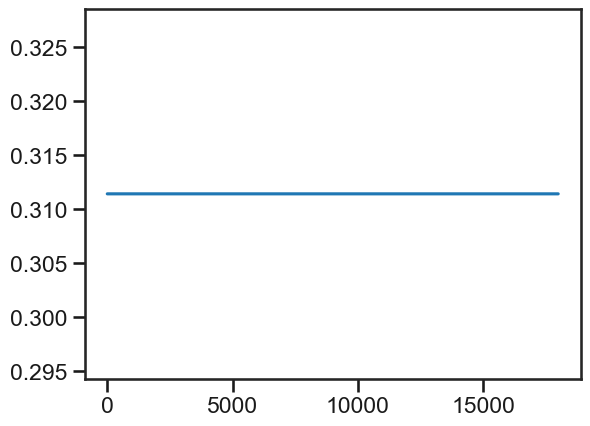

In [50]:
plt.plot(forgettings)

In [82]:
analyticals

array([[[[-7.31597618e-08,  2.97732483e-08, -2.33884745e-09,
          -5.44277468e-08,  2.05136788e-08],
         [-9.98079092e-08, -3.65724431e-08, -3.27413555e-08,
          -4.03440479e-08,  3.79661479e-08],
         [-7.69041323e-08,  1.98273907e-08,  2.54717811e-08,
          -7.61922169e-09,  1.58047832e-08],
         [ 3.05440017e-08, -4.35202095e-08, -1.91434140e-08,
          -5.31105523e-08, -1.42408160e-08],
         [ 8.50035108e-08, -3.95772657e-09, -6.95091262e-08,
           6.96560008e-08, -2.04421637e-08],
         [ 2.83900784e-08, -1.30689783e-08, -3.19752314e-08,
          -1.42090853e-10, -8.66731871e-09]],

        [[-7.27861468e-08,  3.04150011e-08, -3.88440023e-09,
          -5.30770622e-08,  1.97725495e-08],
         [-1.00443434e-07, -3.63785407e-08, -3.36379607e-08,
          -3.99855037e-08,  3.72700208e-08],
         [-7.54076457e-08,  2.02432391e-08,  2.53196019e-08,
          -6.89587697e-09,  1.47246392e-08],
         [ 3.03081237e-08, -4.30099269e-08, 

In [ ]:
#The minimum loss one task is at the end of training, so just take it at that index




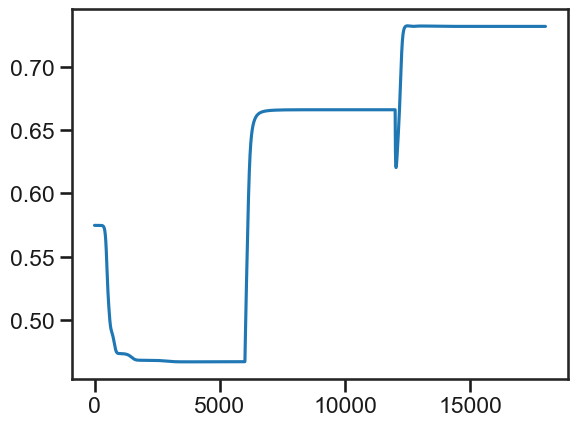

In [65]:
plt.plot(losses[0])


loss_j = losses[0][6000*2]


fs = []

for i in range(12000, 18000):
    fs.append(losses[0][i] - loss_j)

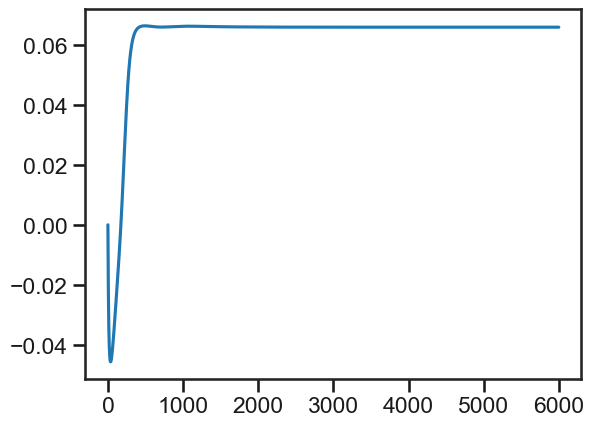

In [67]:
plt.plot(fs)

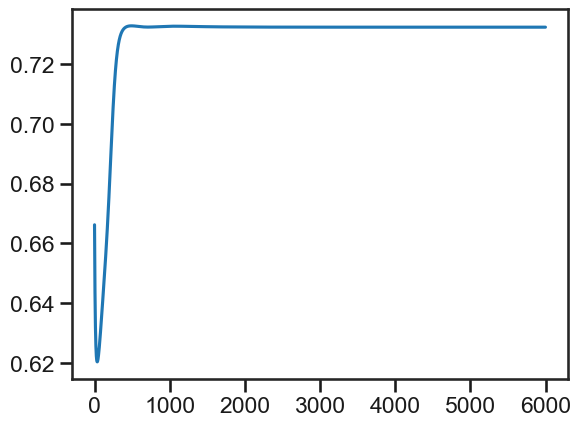

In [68]:
plt.plot(losses[0][12000:])

In [13]:
losses

array([[0.5390064 , 0.5390064 , 0.5390064 , ..., 0.6587019 , 0.6587019 ,
        0.6587019 ],
       [0.4373357 , 0.4373357 , 0.4373357 , ..., 0.548477  , 0.548477  ,
        0.548477  ],
       [0.65498245, 0.65498245, 0.65498245, ..., 0.7195347 , 0.7195347 ,
        0.7195347 ],
       [0.4578839 , 0.4578839 , 0.4578839 , ..., 0.35987777, 0.35987777,
        0.35987777]], dtype=float32)

In [79]:
slope = pd.Series(np.gradient(fs), name='slope')

<AxesSubplot: >

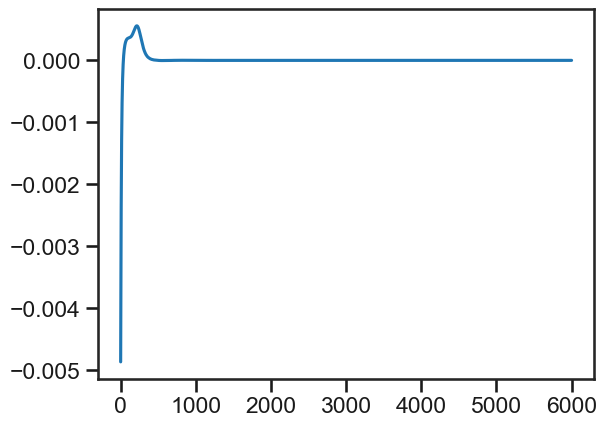

In [81]:
slope.plot()

In [76]:
fs_dev = get_derivatives(fs)

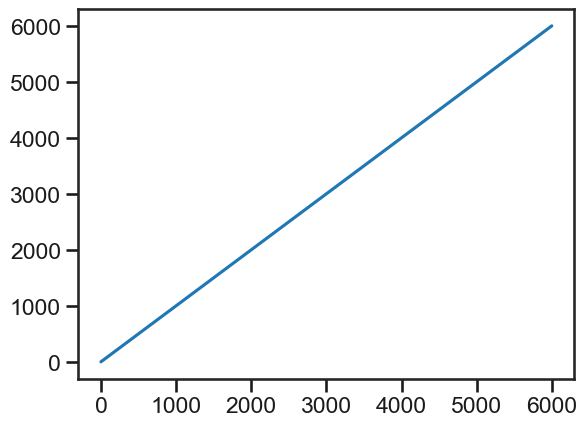

In [77]:
plt.plot(fs_dev)

In [84]:
data_i

Array([[-0.0529983 ,  0.64639175,  0.7463098 ,  0.44093022,  0.643022  ],
       [ 1.1417167 ,  0.9438895 , -1.4578416 , -0.56424093,  0.12449063],
       [ 0.60503894,  0.6241629 , -0.7254051 , -0.7760621 ,  0.560258  ],
       [-0.20140058,  0.2817104 ,  1.0893216 , -0.7744287 ,  0.26746258],
       [-1.670098  , -2.7028468 , -0.41984853, -1.1651106 , -0.6414284 ],
       [-0.7123282 ,  0.15073724, -0.548768  ,  1.6529007 ,  1.3020163 ],
       [ 1.026436  , -0.3838975 , -0.23740014, -1.6011696 ,  0.87979287],
       [-0.21279885,  0.10081055, -1.3538324 , -1.4661961 , -0.7049546 ],
       [ 1.0297912 ,  0.9084044 ,  1.273965  , -0.9044206 ,  1.021069  ],
       [-0.06037112,  0.18233548,  1.3959895 , -0.78819996,  1.1381044 ],
       [ 0.8053745 , -0.98129565, -0.5397905 ,  1.380811  , -1.8418235 ],
       [-0.08032776, -1.0875777 ,  0.8257851 ,  1.4375441 ,  1.0495017 ],
       [ 0.59111243,  0.09392908,  0.9238556 , -0.15497912, -1.5870957 ],
       [ 1.6783363 ,  0.7822451 , -0.1

In [85]:
from scipy.cluster.vq import whiten

<AxesSubplot: >

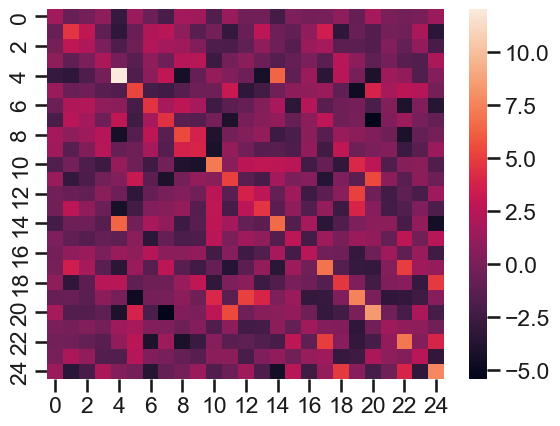

In [87]:
sns.heatmap(data_i@data_i.T)

<AxesSubplot: >

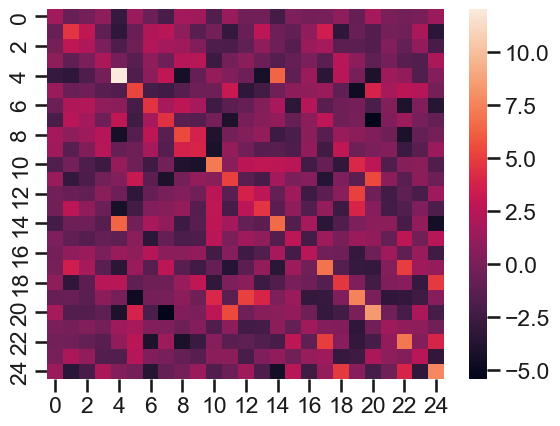

In [89]:
a = whiten(data_i)

sns.heatmap(a @ a.T)

In [99]:
np.linalg.norm(a@a.T - np.eye(a.shape[0]))

53.85165166899901

<AxesSubplot: >

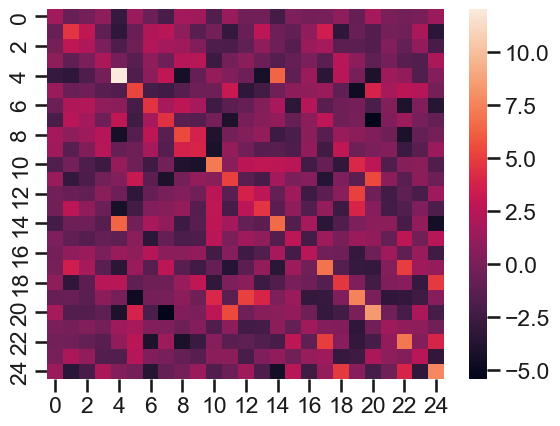

In [101]:
sns.heatmap(a@a.T)

<AxesSubplot: >

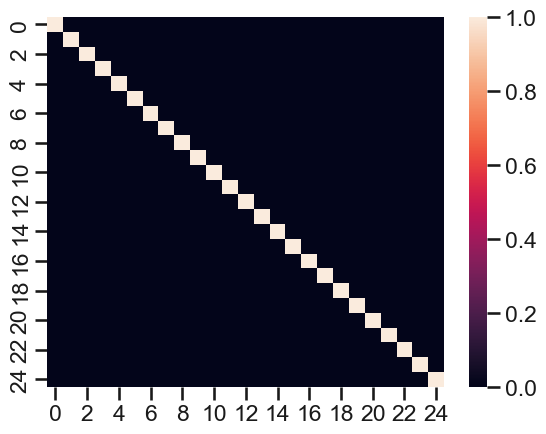

In [100]:
sns.heatmap(np.eye(a.shape[0]))

In [94]:
whiten(data_i)

array([[-0.0529983 ,  0.64639175,  0.74630976,  0.44093022,  0.64302206],
       [ 1.1417167 ,  0.9438895 , -1.4578415 , -0.56424093,  0.12449065],
       [ 0.60503894,  0.6241629 , -0.72540504, -0.7760621 ,  0.56025803],
       [-0.20140058,  0.2817104 ,  1.0893215 , -0.7744287 ,  0.2674626 ],
       [-1.670098  , -2.7028468 , -0.41984847, -1.1651106 , -0.6414285 ],
       [-0.7123282 ,  0.15073724, -0.5487679 ,  1.6529007 ,  1.3020164 ],
       [ 1.026436  , -0.3838975 , -0.23740011, -1.6011696 ,  0.879793  ],
       [-0.21279885,  0.10081055, -1.3538322 , -1.4661961 , -0.7049547 ],
       [ 1.0297912 ,  0.9084044 ,  1.2739649 , -0.9044206 ,  1.0210692 ],
       [-0.06037112,  0.18233548,  1.3959894 , -0.78819996,  1.1381046 ],
       [ 0.8053745 , -0.98129565, -0.53979045,  1.380811  , -1.8418237 ],
       [-0.08032776, -1.0875777 ,  0.825785  ,  1.4375441 ,  1.0495018 ],
       [ 0.59111243,  0.09392908,  0.9238555 , -0.15497912, -1.587096  ],
       [ 1.6783363 ,  0.7822451 , -0.1

In [91]:
data_i

Array([[-0.0529983 ,  0.64639175,  0.7463098 ,  0.44093022,  0.643022  ],
       [ 1.1417167 ,  0.9438895 , -1.4578416 , -0.56424093,  0.12449063],
       [ 0.60503894,  0.6241629 , -0.7254051 , -0.7760621 ,  0.560258  ],
       [-0.20140058,  0.2817104 ,  1.0893216 , -0.7744287 ,  0.26746258],
       [-1.670098  , -2.7028468 , -0.41984853, -1.1651106 , -0.6414284 ],
       [-0.7123282 ,  0.15073724, -0.548768  ,  1.6529007 ,  1.3020163 ],
       [ 1.026436  , -0.3838975 , -0.23740014, -1.6011696 ,  0.87979287],
       [-0.21279885,  0.10081055, -1.3538324 , -1.4661961 , -0.7049546 ],
       [ 1.0297912 ,  0.9084044 ,  1.273965  , -0.9044206 ,  1.021069  ],
       [-0.06037112,  0.18233548,  1.3959895 , -0.78819996,  1.1381044 ],
       [ 0.8053745 , -0.98129565, -0.5397905 ,  1.380811  , -1.8418235 ],
       [-0.08032776, -1.0875777 ,  0.8257851 ,  1.4375441 ,  1.0495017 ],
       [ 0.59111243,  0.09392908,  0.9238556 , -0.15497912, -1.5870957 ],
       [ 1.6783363 ,  0.7822451 , -0.1

In [107]:
X  = np.array([[1.9, 2.3, 1.7],
                      [1.5, 2.5, 2.2],
                      [0.8, 0.6, 1.7,]])

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [108]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

pca = PCA(whiten=True)
X_whitened = pca.fit_transform(X_standardized)

In [105]:
b@b.T

array([[ 76.76755845,  89.02316662,  61.27392128],
       [ 89.02316662, 106.60801421,  75.1906718 ],
       [ 61.27392128,  75.1906718 ,  55.61218704]])

In [110]:
X

array([[1.9, 2.3, 1.7],
       [1.5, 2.5, 2.2],
       [0.8, 0.6, 1.7]])

In [111]:
X_whitened@X_whitened.T

array([[ 2.00000000e+00, -9.15665981e-17, -9.17267705e-19],
       [-9.15665981e-17,  2.00000000e+00, -2.02588901e-16],
       [-9.17267705e-19, -2.02588901e-16,  2.00000000e+00]])